<center>

![huawei-logo](https://www-file.huawei.com/-/media/corporate/images/home/logo/huawei_logo.png)

<p><b>Летняя школа. "Современные методы теории информации, оптимизации и управления".</p></b>
Sirius-2020.
<center> <b>Авторы материала: к.т.н. Антонов Лев, Власов Роман.



## Применение AutoKeras к задаче DPD

In [8]:
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1 &> /dev/null
!pip install autokeras &> /dev/null
!git clone https://gitlab.com/spbroma/pyplot_lib.git &> /dev/null

In [9]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt
from matplotlib.pyplot import grid

In [ ]:
# Import signal from Google Drive

#import scipy.io
#import subprocess
#import os

#from google.colab import drive
#drive.mount('/content/drive')
# import signal
#mat = scipy.io.loadmat('/content/drive/My Drive/Colab Notebooks/datasets/BlackBoxData_80.mat')
#mat = scipy.io.loadmat('../../../../../_datasets/dpd/BlackBoxData/BlackBoxData_80.mat')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# Import signal from github

import scipy.io
import subprocess
import os
# import signal
#mat = scipy.io.loadmat('/content/drive/My Drive/Colab Notebooks/datasets/BlackBoxData_80.mat')

# raw=true is important so you download the file rather than the webpage.
!wget https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/blob/master/BlackBoxData_80.mat?raw=true
# rename the file
!mv BlackBoxData_80.mat\?raw\=true BlackBoxData_80.mat
# update scipy
#!pip install -U -q scipy
# Load the data
mat = scipy.io.loadmat('BlackBoxData_80.mat')

--2020-08-13 09:58:21--  https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/blob/master/BlackBoxData_80.mat?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/raw/master/BlackBoxData_80.mat [following]
--2020-08-13 09:58:22--  https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData/raw/master/BlackBoxData_80.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Huawei-Sirius-Summer-2020/BlackBoxData/master/BlackBoxData_80.mat [following]
--2020-08-13 09:58:23--  https://raw.githubusercontent.com/Huawei-Sirius-Summer-2020/BlackBoxData/master/BlackBoxData_80.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.

In [11]:
x = (mat['x'] * (2 ** -15)).reshape(-1, 1)
y = (mat['y'] * (2 ** -15)).reshape(-1, 1)

X = np.concatenate((np.real(x), np.imag(x)), axis=1)
Y = np.concatenate((np.real(y), np.imag(y)), axis=1)

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

> В предыдущем примере сигнал подавался на вход алгоритма генерации нейронной сети в виде двух склеенных векторов (реальной и мнимой частей). Теперь давайте рассмотрим **другой вариант представления данных**.

> Рассмотрим сигнал снятый с усилителя.

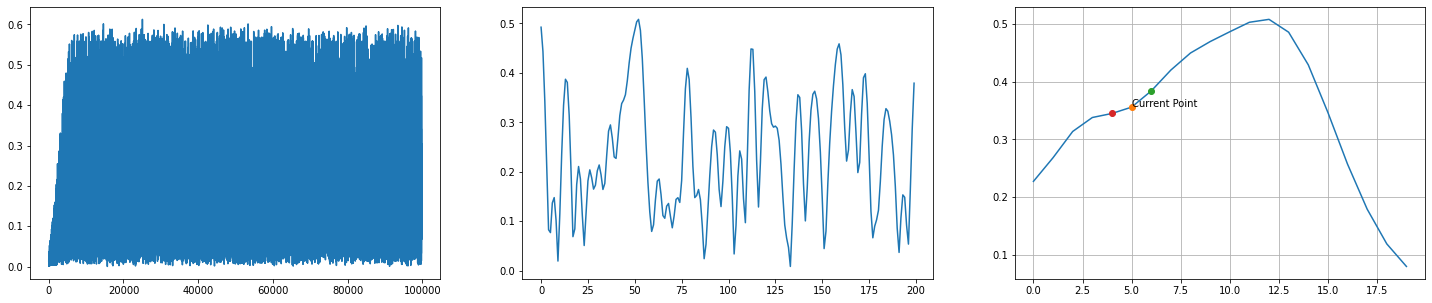

In [ ]:
fig, axes1 = plt.subplots(1, 3, figsize=(25, 5))
axes1[0].plot(np.abs(x))
axes1[1].plot(np.abs(x[8300:8500]))
axes1[2].plot(np.abs(x[8340:8360]))
axes1[2].plot(5, np.abs(x[8345]), marker = "o", label='current sample')
axes1[2].annotate('Current Point', (5, np.abs(x[8345])))
axes1[2].plot(6, np.abs(x[8346]), marker = "o")
axes1[2].plot(4, np.abs(x[8344]), marker = "o")
grid('on')

#plt.plot(np.abs(x))

> Из графиков видно, как непредсказуемо возрастает и падает амплитуда сигнала в результате чего на кривой изменения abs сигнала есть восходящие и нисходящие тренды. Чтобы модель понимала, какой тренд присутствует сейчас в текущей точке давайте передадим текущий сэмпл вместе с предыдущим и последующим, чтобы модель могла учиться находить закономерности и тренды в сигнале.

> Вводим понятие **"модели с памятью"**.






In [6]:
# Функция формирования матрицы сигнала со смещением
def shift_df(df, delay):
  df_new = []
  for i in np.arange(-delay, delay + 1):
    df_new.append(df.shift(periods=i, fill_value=0))

  df_new = pd.concat(df_new, axis=1)
  return df_new

In [ ]:
A = pd.DataFrame([1+1j, 2+2j, 3-1j, 4+7j])
A

,0
0,1.000000+1.000000j
1,2.000000+2.000000j
2,3.000000-1.000000j
3,4.000000+7.000000j


In [ ]:
# Матрица A, содержащая сигнал с задержками
shift_df(A, 1)

,0,0,0
0,2.000000+2.000000j,1.000000+1.000000j,0.000000+0.000000j
1,3.000000-1.000000j,2.000000+2.000000j,1.000000+1.000000j
2,4.000000+7.000000j,3.000000-1.000000j,2.000000+2.000000j
3,0.000000+0.000000j,4.000000+7.000000j,3.000000-1.000000j


In [ ]:
shift_df(X, 1)

,0,1,0,1,0,1
0,-0.007660,-0.017914,0.002380,-0.013489,0.000000,0.000000
1,-0.015259,-0.017792,-0.007660,-0.017914,0.002380,-0.013489
2,-0.018250,-0.012939,-0.015259,-0.017792,-0.007660,-0.017914
3,-0.016083,-0.004303,-0.018250,-0.012939,-0.015259,-0.017792
4,-0.009918,0.006195,-0.016083,-0.004303,-0.018250,-0.012939
...,...,...,...,...,...,...
99835,0.053253,0.060852,-0.006958,0.080994,-0.047638,0.111328
99836,0.103882,0.046875,0.053253,0.060852,-0.006958,0.080994
99837,0.117188,0.032227,0.103882,0.046875,0.053253,0.060852
99838,0.077148,0.012268,0.117188,0.032227,0.103882,0.046875


### Симуляция 1

Разделим сформированную матрицу на train и validation и передадим в модель.
Регрессор запустим всего с одной моделью (max_trials = 1), что бы понять как увеличение количества признаков повлияет на результат.

In [13]:
s = int(X.shape[0] * 0.9)
x_train = X[:s]; x_val = X[s:]
y_train = Y[:s]; y_val = Y[s:]

In [ ]:
x_train_del = shift_df(pd.DataFrame(x_train), 1)
x_val_del   = shift_df(pd.DataFrame(x_val), 1)
x_train_del.shape, y_train.shape, x_val_del.shape, y_val.shape

((89856, 6), (89856, 2), (9984, 6), (9984, 2))

In [ ]:
OUTPUT_PATH = '6_AutoML_Regression_pdp'

# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials=1,
    directory  = OUTPUT_PATH,
    seed = 123) 

reg.fit(x_train_del,
        y_train,
        # Use your own validation set.
        validation_data=(x_val_del, y_val),
        epochs=10)

Trial 1 Complete [00h 00m 37s]
val_loss: 3.6135254049440846e-05

Best val_loss So Far: 3.6135254049440846e-05
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
2808/2808 [==============================] - 4s 1ms/step - loss: 1.2355e-04 - mean_squared_error: 1.2355e-04 - val_loss: 8.3403e-05 - val_mean_squared_error: 8.3403e-05
Epoch 2/10
2808/2808 [==============================] - 4s 1ms/step - loss: 7.1161e-05 - mean_squared_error: 7.1161e-05 - val_loss: 7.1545e-05 - val_mean_squared_error: 7.1545e-05
Epoch 3/10
2808/2808 [==============================] - 4s 1ms/step - loss: 6.1240e-05 - mean_squared_error: 6.1240e-05 - val_loss: 6.3623e-05 - val_mean_squared_error: 6.3623e-05
Epoch 4/10
2808/2808 [==============================] - 4s 1ms/step - loss: 5.4549e-05 - mean_squared_error: 5.4549e-05 - val_loss: 5.7503e-05 - val_mean_squared_error: 5.7503e-05
Epoch 5/10
2808/2808 [==============================] - 4s 1ms/step - loss: 4.9455e-05 - mean_square

In [ ]:
model = reg.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               1792      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 2)                 514       
Total params: 2,306
Trainable params: 2,306
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_ = reg.predict(x_val_del)

In [ ]:
y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
y_val_cmpx  = np.vectorize(complex)(np.array(y_val)[:,0], np.array(y_val)[:,1])
x_val_cmpx  = np.vectorize(complex)(np.array(x_val)[:,0], np.array(x_val)[:,1])

In [ ]:
ex = x_val_cmpx * np.conj(x_val_cmpx)
ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-29.300411377048107+0j)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


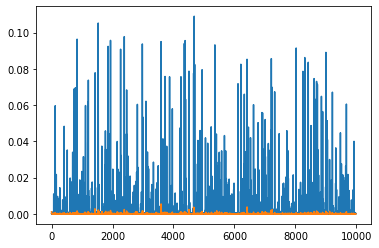

In [ ]:
plt.plot(y_val_cmpx * np.conj(y_val_cmpx))
plt.plot(ee)

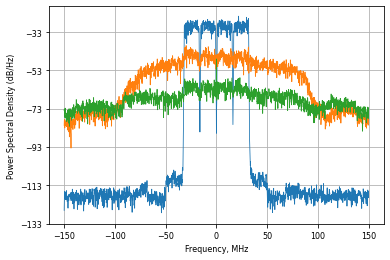

In [ ]:
from pyplot_lib.plot_lib import plot_psd
plot_psd([x_val_cmpx, y_val_cmpx, y_val_cmpx - y_pred_cmpx])

Но как понять, какое количество сэмплов нужно задержать, чтобы алгоритм еще улучшил перформанс? 

### Симуляция 2

Из предыдущих экспериментов мы знаем, что увеличение времени ожидания, не приводит к существенному улучшению результата, поэтому давайте зафиксируем параметры **max_trials=1 и epochs=10** и проведем несколько последовательных симуляций:


*   Тест №1. Запуск Autokeras на чистом сигнале.
*   Тест №2. Запуск Autokeras на матрице, содержащей смещение сигнала в диапазоне [-1, 1].
*   Тест №3. Запуск Autokeras на матрице, содержащей смещение сигнала в диапазоне [-2, 2].
*   ... 
*   Тест №3. Запуск Autokeras на матрице, содержащей смещение сигнала в диапазоне [-10, 10]

Обратите внимание, что **seed** в данном случае мы намеренно не фиксируем.





In [ ]:
nmse_   = []
models  = []
y_preds = []
ee_     = []

for i in np.arange(10):
  x_train_del = shift_df(pd.DataFrame(x_train), i)
  x_val_del   = shift_df(pd.DataFrame(x_val), i)
  
  OUTPUT_PATH = '6_AutoML_Regression_pdp_' + str(i)

  # Initialize the structured data regressor.
  reg = ak.StructuredDataRegressor(
      overwrite=True,
      max_trials=1,
      directory  = OUTPUT_PATH) 

  reg.fit(x_train_del,
        y_train,
        # Use your own validation set.
        validation_data=(x_val_del, y_val),
        epochs=10)
  
  model = reg.export_model()
  models.append(model)

  y_ = reg.predict(x_val_del)

  y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
  y_val_cmpx  = np.vectorize(complex)(np.array(y_val)[:,0], np.array(y_val)[:,1])
  x_val_cmpx  = np.vectorize(complex)(np.array(x_val)[:,0], np.array(x_val)[:,1])
  y_preds.append(y_pred_cmpx)

  ex = x_val_cmpx * np.conj(x_val_cmpx)
  ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
  nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
  nmse_.append(nmse)
  ee_.append(ee)

  print(nmse_)

Trial 1 Complete [00h 01m 27s]
val_loss: 0.0002734130830504

Best val_loss So Far: 0.0002734130830504
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
2808/2808 [==============================] - 9s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/10
2808/2808 [==============================] - 9s 3ms/step - loss: 9.8167e-04 - mean_squared_error: 9.8167e-04 - val_loss: 7.3727e-04 - val_mean_squared_error: 7.3727e-04
Epoch 3/10
2808/2808 [==============================] - 9s 3ms/step - loss: 8.0946e-04 - mean_squared_error: 8.0946e-04 - val_loss: 6.6317e-04 - val_mean_squared_error: 6.6317e-04
Epoch 4/10
2808/2808 [==============================] - 9s 3ms/step - loss: 7.8819e-04 - mean_squared_error: 7.8819e-04 - val_loss: 7.1853e-04 - val_mean_squared_error: 7.1853e-04
Epoch 5/10
2808/2808 [==============================] - 9s 3ms/step - loss: 6.8765e-04 - mean_squared_error: 6.8765e-04 - va

In [ ]:
nmse_

[(-22.93000078858705+0j),
 (-20.745862464354975+0j),
 (-31.37628552938759+0j),
 (-17.67228768349366+0j),
 (-32.659672225863474+0j),
 (-19.34522272387303+0j),
 (-20.35513329716894+0j),
 (-19.824301675143992+0j),
 (-25.473210689463414+0j),
 (-21.65162043234411+0j)]

### Повторный запуск

Так как параметр seed мы не фиксировали, то запустим эксперимент еще раз и оценим результаты.

In [ ]:
nmse_2   = []
models_2  = []
y_preds_2 = []
ee_2     = []

for i in np.arange(10):
  x_train_del = shift_df(pd.DataFrame(x_train), i)
  x_val_del   = shift_df(pd.DataFrame(x_val), i)
  
  OUTPUT_PATH = '6_AutoML_Regression_pdp_2' + str(i)

  # Initialize the structured data regressor.
  reg = ak.StructuredDataRegressor(
      overwrite=True,
      max_trials=1,
      directory  = OUTPUT_PATH,
      seed = 123) 

  reg.fit(x_train_del,
        y_train,
        # Use your own validation set.
        validation_data=(x_val_del, y_val),
        epochs=10)
  
  model = reg.export_model()
  models_2.append(model)

  y_ = reg.predict(x_val_del)

  y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
  y_val_cmpx  = np.vectorize(complex)(np.array(y_val)[:,0], np.array(y_val)[:,1])
  x_val_cmpx  = np.vectorize(complex)(np.array(x_val)[:,0], np.array(x_val)[:,1])
  y_preds_2.append(y_pred_cmpx)

  ex = x_val_cmpx * np.conj(x_val_cmpx)
  ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
  nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
  nmse_2.append(nmse)
  ee_2.append(ee)

  print(nmse_2)

Trial 1 Complete [00h 00m 55s]
val_loss: 2.66437327809399e-05

Best val_loss So Far: 2.66437327809399e-05
Total elapsed time: 00h 00m 55s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
2808/2808 [==============================] - 5s 2ms/step - loss: 2.9275e-04 - mean_squared_error: 2.9275e-04 - val_loss: 8.7950e-05 - val_mean_squared_error: 8.7950e-05
Epoch 2/10
2808/2808 [==============================] - 5s 2ms/step - loss: 5.5051e-05 - mean_squared_error: 5.5051e-05 - val_loss: 7.3351e-05 - val_mean_squared_error: 7.3351e-05
Epoch 3/10
2808/2808 [==============================] - 5s 2ms/step - loss: 4.4506e-05 - mean_squared_error: 4.4506e-05 - val_loss: 5.5746e-05 - val_mean_squared_error: 5.5746e-05
Epoch 4/10
2808/2808 [==============================] - 5s 2ms/step - loss: 4.0559e-05 - mean_squared_error: 4.0559e-05 - val_loss: 6.0508e-05 - val_mean_squared_error: 6.0508e-05
Epoch 5/10
2808/2808 [==============================] - 5s 2ms/step - loss: 3.6998e-05 - mean_squared_er

In [ ]:
# Результаты первой симуляции
nmse_

[(-19.616941921465244+0j),
 (-16.188583666102943+0j),
 (-21.553395785372885+0j),
 (-26.707248565557926+0j),
 (-17.038104437828842+0j),
 (-24.57686822899167+0j),
 (-22.47669525235491+0j),
 (-19.36045523010784+0j),
 (-17.848394277556086+0j),
 (-21.52750453368551+0j)]

In [ ]:
# Результаты второй симуляции
nmse_2

[(-23.440443412471318+0j),
 (-29.300411377048107+0j),
 (-32.12652453661657+0j),
 (-31.783256372969355+0j),
 (-31.326661998955938+0j),
 (-29.534672474353123+0j),
 (-30.05953065217122+0j),
 (-28.719063304959427+0j),
 (-29.551262300077813+0j),
 (-28.73404962444155+0j)]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


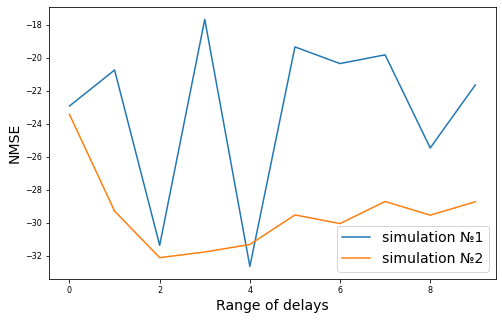

In [ ]:
fig, ax = plt.subplots()

ax.plot(nmse_, label = 'simulation №1')
ax.plot(nmse_2, label = 'simulation №2')

ax.legend(fontsize = 14)
plt.xlabel("Range of delays", fontsize=14)
plt.ylabel("NMSE", fontsize=14)

fig.set_figheight(5)
fig.set_figwidth(8)

plt.show()

К сожалению, из-за большой стахостичности алгоритма, невозможно оценить, какая же память нужна для автоматичекого поиска нейросетевых архитектур, исходя из результатов только 2 экспериментов. Но мы видим, что исходя из полученных результатов, **память [-2;2] и [-4;4]** показали наилучший перформанс. Скорее всего, это не более, чем случайность, но давайте возмем датасет со смещением [-2;2] и запустим на нем более долгую симуляцию.

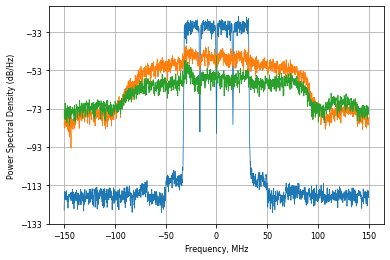

In [ ]:
plot_psd([x_val_cmpx, y_val_cmpx, y_val_cmpx - y_preds_2[0]])

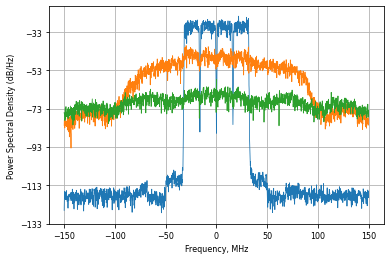

In [ ]:
ind = np.argmin(nmse_2)
plot_psd([x_val_cmpx, y_val_cmpx, y_val_cmpx - y_preds_2[ind]])

Текст об оптимальном размере датасета и параметров

### Симуляция 3.

Установим параметры поиска моделей **max_trials=7, epochs=30** и передадим датасет со смещением **[-2;2]**.

In [14]:
ind = 2
x_train_del = shift_df(pd.DataFrame(x_train), ind)
x_val_del   = shift_df(pd.DataFrame(x_val), ind)
x_train_del.shape, y_train.shape, x_val_del.shape, y_val.shape

((89856, 10), (89856, 2), (9984, 10), (9984, 2))

In [15]:
OUTPUT_PATH = '6_AutoML_Regression_pdp_5'

# Initialize the structured data regressor.
reg_5 = ak.StructuredDataRegressor(
    overwrite = True,
    max_trials = 7,
    directory  = OUTPUT_PATH,
    seed = 123)

In [16]:
reg_5.fit(x_train_del,
        y_train,
        # Use your own validation set.
        validation_data=(x_val_del, y_val),
        epochs=30)

Trial 7 Complete [00h 01m 33s]
val_loss: 4.622768028639257e-05

Best val_loss So Far: 2.1778343580081128e-05
Total elapsed time: 00h 23m 56s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
2808/2808 [==============================] - 4s 1ms/step - loss: 1.1794e-04 - mean_squared_error: 1.1794e-04 - val_loss: 4.4146e-05 - val_mean_squared_error: 4.4146e-05
Epoch 2/30
2808/2808 [==============================] - 4s 1ms/step - loss: 4.5596e-05 - mean_squared_error: 4.5596e-05 - val_loss: 3.6985e-05 - val_mean_squared_error: 3.6985e-05
Epoch 3/30
2808/2808 [==============================] - 4s 1ms/step - loss: 3.8797e-05 - mean_squared_error: 3.8797e-05 - val_loss: 2.9951e-05 - val_mean_squared_error: 2.9951e-05
Epoch 4/30
2808/2808 [==============================] - 4s 1ms/step - loss: 3.3707e-05 - mean_squared_error: 3.3707e-05 - val_loss: 2.5631e-05 - val_mean_squared_error: 2.5631e-05
Epoch 5/30
2808/2808 [==============================] - 4s 1ms/step - loss: 3.0996e-05 - mean_squared

In [17]:
model_5 = reg_5.export_model()
model_5.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 2)                 514       
Total params: 3,330
Trainable params: 3,330
Non-trainable params: 0
_________________________________________________________________


In [18]:
y_ = reg_5.predict(x_val_del)

In [19]:
y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
y_val_cmpx  = np.vectorize(complex)(np.array(y_val)[:,0], np.array(y_val)[:,1])
x_val_cmpx  = np.vectorize(complex)(np.array(x_val)[:,0], np.array(x_val)[:,1])

In [20]:
ex = x_val_cmpx * np.conj(x_val_cmpx)
ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
nmse

(-33.25164758242147+0j)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


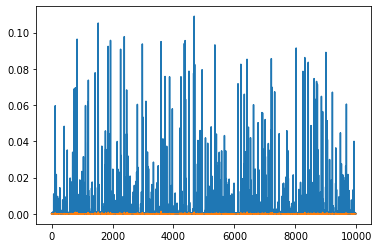

In [21]:
plt.plot(y_val_cmpx * np.conj(y_val_cmpx))
plt.plot(ee)

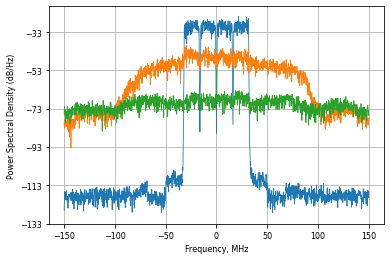

In [22]:
from pyplot_lib.plot_lib import plot_psd
plot_psd([x_val_cmpx, y_val_cmpx, (y_val_cmpx - y_pred_cmpx)])

### Симуляция 4

Теперь давайте увеличим диапазон поиска памяти модели от [-20;20], так как для некоторых сигналов это может иметь смысл. Увеличим количество проводимых симуляций до 10, чтобы иметь возможность оценить дисперсию и мат. ожидание полученных результатов.

In [ ]:
import collections

In [ ]:
%%time

numSimulations = 11
DelayRange     = 21

nmse_dict    = collections.defaultdict(list)
models_dict  = collections.defaultdict(list)
y_preds_dict = collections.defaultdict(list)
ee_dict      = collections.defaultdict(list)

for j in np.arange(numSimulations):
  nmse_3    = []
  models_3  = []
  y_preds_3 = []
  ee_3      = []

  for i in np.arange(DelayRange):
    print('=============== Simulation #%d ===============' % j)
    print()
    print('#---------------Current delays range [-%d, %d]---------------#' % (-i, i))
    x_train_del = shift_df(pd.DataFrame(x_train), i)
    x_val_del   = shift_df(pd.DataFrame(x_val), i)
    
    OUTPUT_PATH = '6_AutoML_Regression_pdp_3' + str(i)

    # Initialize the structured data regressor.
    reg = ak.StructuredDataRegressor(
        overwrite=True,
        max_trials=1,
        directory  = OUTPUT_PATH) 

    reg.fit(x_train_del,
          y_train,
          # Use your own validation set.
          validation_data=(x_val_del, y_val),
          epochs=10)
    
    model = reg.export_model()
    models_3.append(model)

    y_ = reg.predict(x_val_del)

    y_pred_cmpx = np.vectorize(complex)(y_[:,0]   , y_[:,1])
    y_val_cmpx  = np.vectorize(complex)(np.array(y_val)[:,0], np.array(y_val)[:,1])
    x_val_cmpx  = np.vectorize(complex)(np.array(x_val)[:,0], np.array(x_val)[:,1])
    y_preds_3.append(y_pred_cmpx)

    ex = x_val_cmpx * np.conj(x_val_cmpx)
    ee = (y_val_cmpx - y_pred_cmpx) * np.conj(y_val_cmpx - y_pred_cmpx)
    nmse = 10 * np.log10(np.mean(ee) / np.mean(ex))
    nmse_3.append(nmse)
    ee_3.append(ee)

    print('Results of current simulation')
    print(nmse_3)

  nmse_dict[j].append(nmse_3)
  models_dict[j].append(models_3)
  y_preds_dict[j].append(y_preds_3)
  ee_dict[j].append(ee_3)


Trial 1 Complete [00h 01m 08s]
val_loss: 0.0017879890510812402

Best val_loss So Far: 0.0017879890510812402
Total elapsed time: 00h 01m 08s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
2808/2808 [==============================] - 7s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/10
2808/2808 [==============================] - 6s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/10
2808/2808 [==============================] - 7s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
2808/2808 [==============================] - 7s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/10
2808/2808 [==============================] - 7s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Ep

In [ ]:
nmse_dict

defaultdict(list,
            {0: [[(-16.929610941679087+0j),
               (-19.046400129108044+0j),
               (-30.174391615718218+0j),
               (-19.750187614061726+0j),
               (-21.14403935976251+0j),
               (-22.403114520347845+0j),
               (-22.03989495116112+0j),
               (-23.61032739936117+0j),
               (-18.722656811462365+0j),
               (-12.749590740125804+0j),
               (-18.358568016147384+0j),
               (-18.858607820732306+0j),
               (-18.445379447994533+0j),
               (-30.11194954429117+0j),
               (-15.50092665715092+0j),
               (-16.081397020424472+0j),
               (-28.92016722036875+0j),
               (-19.476528487908723+0j),
               (-21.322252932838648+0j),
               (-24.343637420457334+0j),
               (-19.818819513846528+0j)]],
             1: [[(-17.549462114214766+0j),
               (-20.997847976052284+0j),
               (-21.951037510917807+0

In [ ]:
nmse_dict_1 = collections.defaultdict(list,
            {0: [[(-16.929610941679087+0j),
               (-19.046400129108044+0j),
               (-30.174391615718218+0j),
               (-19.750187614061726+0j),
               (-21.14403935976251+0j),
               (-22.403114520347845+0j),
               (-22.03989495116112+0j),
               (-23.61032739936117+0j),
               (-18.722656811462365+0j),
               (-12.749590740125804+0j),
               (-18.358568016147384+0j),
               (-18.858607820732306+0j),
               (-18.445379447994533+0j),
               (-30.11194954429117+0j),
               (-15.50092665715092+0j),
               (-16.081397020424472+0j),
               (-28.92016722036875+0j),
               (-19.476528487908723+0j),
               (-21.322252932838648+0j),
               (-24.343637420457334+0j),
               (-19.818819513846528+0j)]],
             1: [[(-17.549462114214766+0j),
               (-20.997847976052284+0j),
               (-21.951037510917807+0j),
               (-33.474203400416044+0j),
               (-15.293771972331673+0j),
               (-24.425324255430965+0j),
               (-28.553854480265457+0j),
               (-29.324441299481087+0j),
               (-18.962328829907502+0j),
               (-22.70768289445575+0j),
               (-17.11576966950939+0j),
               (-24.978758611255323+0j),
               (-27.224181036758104+0j),
               (-19.228762294026673+0j),
               (-17.038152171019522+0j),
               (-16.96266217800727+0j),
               (-27.95182977602002+0j),
               (-19.085751224545216+0j),
               (-14.926448038039407+0j),
               (-18.730302722996342+0j),
               (-29.63987876751161+0j)]],
             2: [[(-20.65716269030262+0j),
               (-27.090577951285333+0j),
               (-20.58859071968344+0j),
               (-30.296735286060787+0j),
               (-24.885054673084497+0j),
               (-33.47496530939466+0j),
               (-21.85271004970058+0j),
               (-16.726325896369666+0j),
               (-18.03516479451341+0j),
               (-21.295032622667378+0j),
               (-17.071724853966476+0j),
               (-17.443534704220713+0j),
               (-20.17588514870824+0j),
               (-30.80163471156193+0j),
               (-21.028785354059323+0j),
               (-18.472728902889834+0j),
               (-18.981849249140105+0j),
               (-28.036297442117927+0j),
               (-30.126504749145163+0j),
               (-21.110814147601697+0j),
               (-17.66080273378182+0j)]],
             3: [[(-23.3074650206619+0j),
               (-11.930117899861036+0j),
               (-18.906912198820336+0j),
               (-31.032445409154352+0j),
               (-20.833227296024724+0j),
               (-29.955389200284195+0j),
               (-19.334292428097037+0j),
               (-23.486058140426188+0j),
               (-20.3614643339324+0j),
               (-29.462784733974775+0j),
               (-6.826463648080908+0j),
               (-20.30162229689481+0j),
               (-18.826446708575467+0j),
               (-20.587530828308843+0j),
               (-18.071353528761176+0j),
               (-11.266871795911067+0j),
               (-30.864889606944107+0j),
               (-19.588414403261698+0j),
               (-31.87051312141969+0j),
               (-18.34929596018517+0j),
               (-19.527294756085716+0j)]],
             4: [[(-20.76071188393934+0j),
               (-12.749590740125804+0j),
               (-18.99253652241373+0j),
               (-31.95809285159526+0j),
               (-19.486126003682024+0j),
               (-16.584700442763744+0j),
               (-20.653013931029914+0j),
               (-19.70626859294963+0j),
               (-18.582625983730495+0j),
               (-21.545003130682005+0j),
               (-19.610961387414697+0j),
               (-20.853823911689304+0j),
               (-20.234397510504696+0j),
               (-19.059177872079427+0j),
               (-21.115748590793146+0j),
               (-20.65617877964412+0j),
               (-18.17927729547314+0j),
               (-19.40226969345921+0j),
               (-17.843118115147327+0j),
               (-20.78766788110739+0j),
               (-27.994959412143807+0j)]],
             5: [[(-19.472526749792053+0j),
               (-22.07492091532899+0j),
               (-24.247479512758186+0j),
               (-18.910843378768757+0j),
               (-18.067355525974886+0j),
               (-26.845163667313045+0j),
               (-21.06481887295343+0j),
               (-19.558398315568397+0j),
               (-27.066326659735715+0j),
               (-15.424004217742446+0j),
               (-30.638302274967973+0j),
               (-17.012759243002932+0j),
               (-16.046946295347823+0j),
               (-22.25623879628769+0j),
               (-19.453900322785064+0j),
               (-29.462230619951946+0j),
               (-19.10577460718268+0j),
               (-20.242018610516812+0j),
               (-19.315081857215397+0j),
               (-20.52814745325758+0j),
               (-25.72620126733093+0j)]],
             6: [[(-23.471556854380637+0j),
               (-20.804738767140552+0j),
               (-20.348261843255116+0j),
               (-20.831705823344336+0j),
               (-24.87934608954722+0j),
               (-20.999309008596537+0j),
               (-15.492919170828275+0j),
               (-25.74826462676419+0j),
               (-29.55817266108398+0j),
               (-30.07055887015+0j),
               (-25.735211836891242+0j),
               (-17.585071545560563+0j),
               (-11.344506603423682+0j),
               (-16.444272670693934+0j),
               (-30.54820973037632+0j),
               (-20.06758987249977+0j),
               (-16.591980796638552+0j),
               (-25.9444265152376+0j),
               (-28.681166644939825+0j),
               (-18.605373014935388+0j),
               (-20.131859248110338+0j)]],
             7: [[(-20.172404195390364+0j),
               (-27.918267514131863+0j),
               (-30.80576722338065+0j),
               (-20.644263882283184+0j),
               (-18.379969814860818+0j),
               (-18.715266642488366+0j),
               (-28.985326116813518+0j),
               (-33.61518920727728+0j),
               (-21.067701446389954+0j),
               (-19.592783252308678+0j),
               (-17.847882257299826+0j),
               (-30.001195258245843+0j),
               (-18.493907914307005+0j),
               (-17.192742619707246+0j),
               (-19.326786020963617+0j),
               (-14.207871316058556+0j),
               (-18.74045339691374+0j),
               (-20.02012252654263+0j),
               (-8.218913685057705+0j),
               (-19.8347158738765+0j),
               (-21.765028872842702+0j)]],
             8: [[(-21.569905434384626+0j),
               (-19.80723559214937+0j),
               (-8.863029175131357+0j),
               (-17.639562299265407+0j),
               (-18.825965851738736+0j),
               (-8.033636066395859+0j),
               (-20.769768194376116+0j),
               (-19.238468391878477+0j),
               (-19.226044571614796+0j),
               (-18.68490536363102+0j),
               (-2.5475087807526977+0j),
               (-20.614862414309535+0j),
               (-21.58222912553439+0j),
               (-25.837429193397963+0j),
               (-19.60943715056382+0j),
               (-20.85117981119931+0j),
               (-20.9692306462684+0j),
               (-30.48082800040696+0j),
               (-19.309482131802422+0j),
               (-16.598474362972535+0j),
               (-19.417756652821975+0j)]],
             9: [[(-18.72315052526745+0j),
               (-21.557363799631695+0j),
               (-30.63373462937352+0j),
               (-18.84103229891213+0j),
               (-33.074494977711545+0j),
               (-19.01349958874275+0j),
               (-27.112275046238867+0j),
               (-19.373805070756962+0j),
               (-21.059924798922275+0j),
               (-23.311429879937823+0j),
               (-26.299586810662+0j),
               (-16.299450870300806+0j),
               (-24.614319583907065+0j),
               (-5.477142470841317+0j),
               (-19.656316769822375+0j),
               (-18.80028019815392+0j),
               (-21.198164594155323+0j),
               (-18.736325548494086+0j),
               (-19.511327852587467+0j),
               (-18.18644895231222+0j),
               (-13.933158703234769+0j)]],
             10: [[(-17.86161422888902+0j),
               (-20.74322794670423+0j),
               (-24.662682403436257+0j),
               (-23.563042664196804+0j),
               (-19.725119320256482+0j),
               (-32.97940797989029+0j),
               (-30.76291711530729+0j),
               (-25.976222870806048+0j),
               (-29.59156299415728+0j),
               (-17.325461113422783+0j),
               (-18.137885183461197+0j),
               (-19.591742378050533+0j),
               (-18.68804683302969+0j),
               (-18.862532702046245+0j),
               (-23.31632166176321+0j),
               (-24.492805982938236+0j),
               (-15.726619722776627+0j),
               (-16.83390266212483+0j),
               (-18.58927859032987+0j),
               (-16.32835691308398+0j),
               (-12.749590740125804+0j)]]})

In [ ]:
d_mse = dict()
for i in np.arange(len(nmse_dict_1)):
  d_mse[str(i)] = np.real(nmse_dict_1[i]).reshape(1,-1)[0].tolist()
nmse_df = pd.DataFrame(d_mse).T
nmse_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-16.929611,-19.046400,-30.174392,-19.750188,-21.144039,-22.403115,-22.039895,-23.610327,-18.722657,-12.749591,-18.358568,-18.858608,-18.445379,-30.111950,-15.500927,-16.081397,-28.920167,-19.476528,-21.322253,-24.343637,-19.818820
1,-17.549462,-20.997848,-21.951038,-33.474203,-15.293772,-24.425324,-28.553854,-29.324441,-18.962329,-22.707683,-17.115770,-24.978759,-27.224181,-19.228762,-17.038152,-16.962662,-27.951830,-19.085751,-14.926448,-18.730303,-29.639879
2,-20.657163,-27.090578,-20.588591,-30.296735,-24.885055,-33.474965,-21.852710,-16.726326,-18.035165,-21.295033,-17.071725,-17.443535,-20.175885,-30.801635,-21.028785,-18.472729,-18.981849,-28.036297,-30.126505,-21.110814,-17.660803
3,-23.307465,-11.930118,-18.906912,-31.032445,-20.833227,-29.955389,-19.334292,-23.486058,-20.361464,-29.462785,-6.826464,-20.301622,-18.826447,-20.587531,-18.071354,-11.266872,-30.864890,-19.588414,-31.870513,-18.349296,-19.527295
4,-20.760712,-12.749591,-18.992537,-31.958093,-19.486126,-16.584700,-20.653014,-19.706269,-18.582626,-21.545003,-19.610961,-20.853824,-20.234398,-19.059178,-21.115749,-20.656179,-18.179277,-19.402270,-17.843118,-20.787668,-27.994959
5,-19.472527,-22.074921,-24.247480,-18.910843,-18.067356,-26.845164,-21.064819,-19.558398,-27.066327,-15.424004,-30.638302,-17.012759,-16.046946,-22.256239,-19.453900,-29.462231,-19.105775,-20.242019,-19.315082,-20.528147,-25.726201
6,-23.471557,-20.804739,-20.348262,-20.831706,-24.879346,-20.999309,-15.492919,-25.748265,-29.558173,-30.070559,-25.735212,-17.585072,-11.344507,-16.444273,-30.548210,-20.067590,-16.591981,-25.944427,-28.681167,-18.605373,-20.131859
7,-20.172404,-27.918268,-30.805767,-20.644264,-18.379970,-18.715267,-28.985326,-33.615189,-21.067701,-19.592783,-17.847882,-30.001195,-18.493908,-17.192743,-19.326786,-14.207871,-18.740453,-20.020123,-8.218914,-19.834716,-21.765029
8,-21.569905,-19.807236,-8.863029,-17.639562,-18.825966,-8.033636,-20.769768,-19.238468,-19.226045,-18.684905,-2.547509,-20.614862,-21.582229,-25.837429,-19.609437,-20.851180,-20.969231,-30.480828,-19.309482,-16.598474,-19.417757
9,-18.723151,-21.557364,-30.633735,-18.841032,-33.074495,-19.013500,-27.112275,-19.373805,-21.059925,-23.311430,-26.299587,-16.299451,-24.614320,-5.477142,-19.656317,-18.800280,-21.198165,-18.736326,-19.511328,-18.186449,-13.933159


Text(156.5, 0.5, 'Num. of simulation')

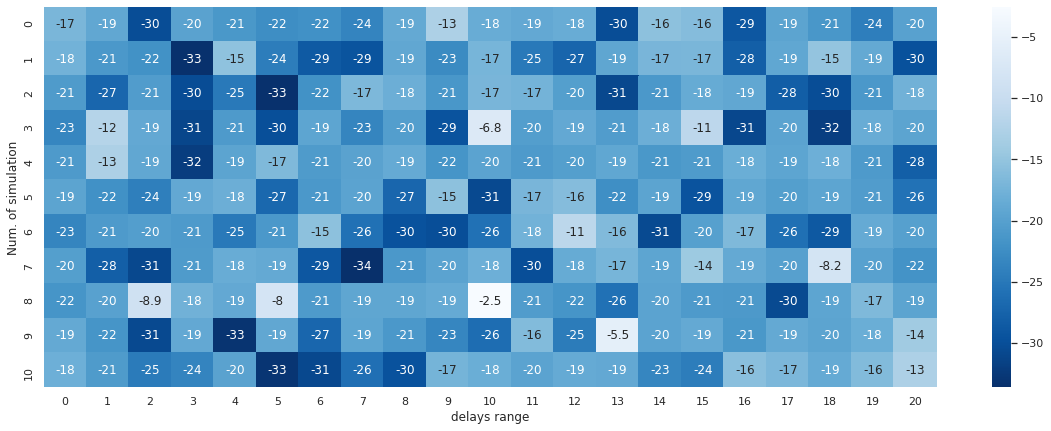

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.subplots(figsize=(20,7))
sns.heatmap(nmse_df, annot=True, cmap="Blues_r")
plt.xlabel('delays range')
plt.ylabel('Num. of simulation')

In [ ]:
nmse_df.mean(axis=0)

0    -20.043234
1    -20.429117
2    -22.743129
3    -24.267465
4    -21.326770
5    -23.039071
6    -23.329254
7    -23.305797
8    -22.021270
9    -21.106294
10   -18.199079
11   -20.321948
12   -19.606931
13   -20.532674
14   -20.424176
15   -19.211072
16   -21.566385
17   -21.622444
18   -20.883099
19   -19.400294
20   -20.760486
dtype: float64

Text(0, 0.5, 'NMSE')

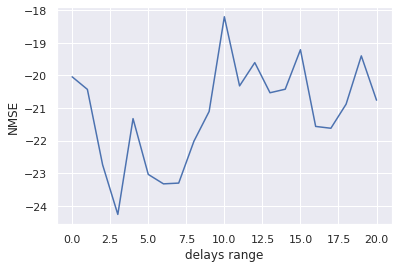

In [ ]:
plt.plot(nmse_df.mean(axis=0))
plt.xlabel('delays range')
plt.ylabel('NMSE')

In [ ]:
xy_best = np.where(nmse_df.to_numpy() == np.min(nmse_df.to_numpy()))
xy_best = [xy_best[0][0], xy_best[1][0]]
xy_best

[7, 7]

In [ ]:
# Лучшая модель 
models_dict[xy_best[0]][0][xy_best[1]].summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               15872     
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 2)                

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


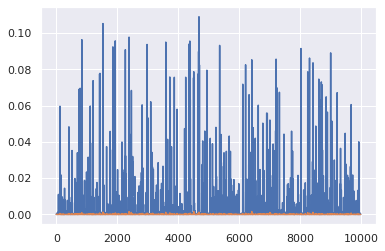

In [ ]:
y_pred = y_preds_dict[xy_best[0]][0][xy_best[1]]
ee = ee_dict[xy_best[0]][0][xy_best[1]]
plt.plot(y_val_cmpx * np.conj(y_val_cmpx))
plt.plot(ee)